<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import networkx as nx
import pdb
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")


### Info
Note that this notebook uses feature vectors of a very large dataset. This makes that some cells can take very long to run, especially in the sections where the model is trained and the graph embedding extraction. In addition memory usage is also high. All outputs are normally already there. It is also easiest to work with Jupyter notebook to run this notebook. All required files are included in the submitted folder and should not be changed of place for the notebook to run correctly.

### Problem statement: 
The problem we try to tackle is to perform a link prediction on a social network graph. The setting this is used in will be in a directed graph where nodes represent people and edges indicate if one person follows another. So link prediction could be used to generate a list for people you might know but you don't follow yet.

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

# Reading graph data
As a first step, we need to read the data given by facebook and store it as a graph g. We work with a subgraph containing 1500000 rows of the train.csv file. This is done to keep the RAM usage limited.

In [3]:
tmp = pd.read_csv('train.csv', nrows=1500000).to_csv('./train_small.csv',header=False,index=False)

Below are properties of the graph.

In [4]:
g=nx.read_edgelist('train_small.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 882535
Number of edges: 1500000
Average in degree:   1.6996
Average out degree:   1.6996


# 1. Exploratory Data Analysis
Exploratory data analysis is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

In this section we will be anylizing the relations established between the Facebook users (nodes) present in the dataset.

In [5]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 882535


## 1.1 No of followers for each person
First, the amount of followers each person has is investigated.

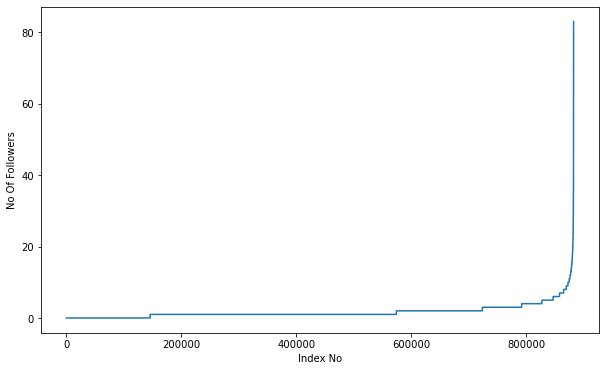

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

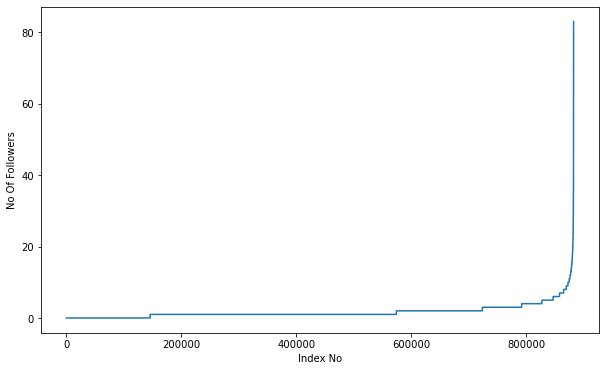

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

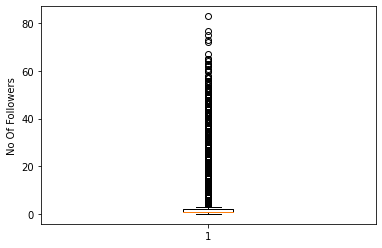

In [8]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [9]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 4.0
91 percentile value is 4.0
92 percentile value is 4.0
93 percentile value is 4.0
94 percentile value is 5.0
95 percentile value is 5.0
96 percentile value is 6.0
97 percentile value is 6.0
98 percentile value is 7.0
99 percentile value is 10.0
100 percentile value is 83.0


In [10]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 10.0
99.2 percentile value is 11.0
99.3 percentile value is 12.0
99.4 percentile value is 12.0
99.5 percentile value is 13.0
99.6 percentile value is 14.0
99.7 percentile value is 16.0
99.8 percentile value is 19.0
99.9 percentile value is 24.0
100.0 percentile value is 83.0


Previous results indicate that most persons have very limited followers (99.9% have less than 23 followers).

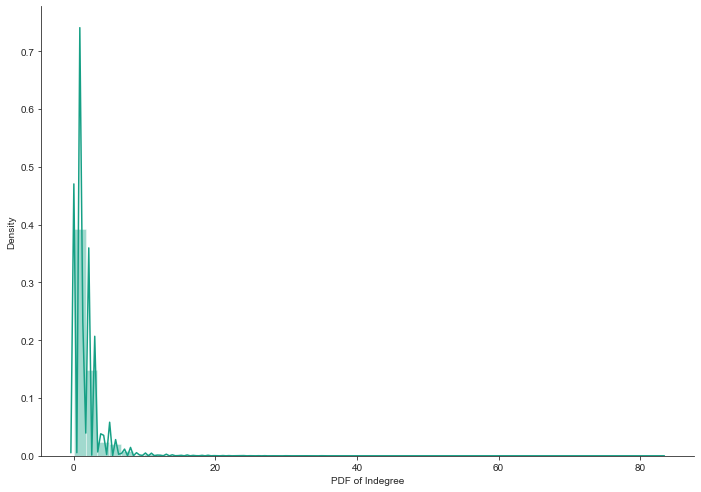

In [11]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No of people each person is following
The same analysis as for the number of followers, but this time looking at the number of followees.

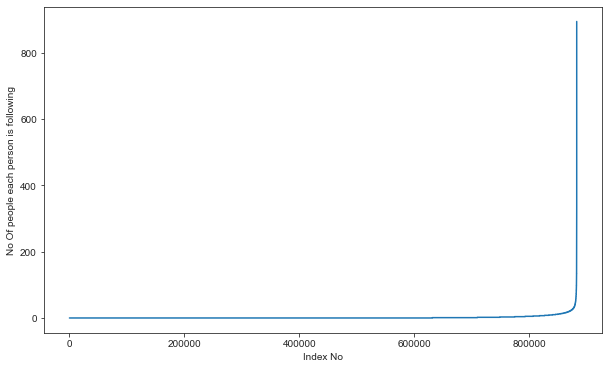

In [12]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

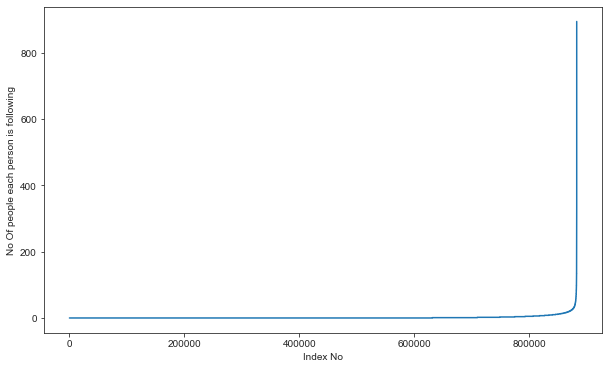

In [13]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

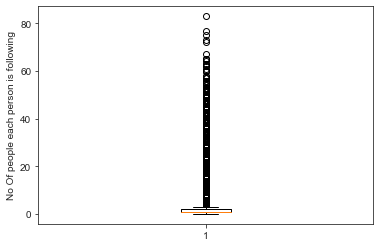

In [14]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [15]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 5.0
91 percentile value is 5.0
92 percentile value is 6.0
93 percentile value is 7.0
94 percentile value is 8.0
95 percentile value is 9.0
96 percentile value is 11.0
97 percentile value is 13.0
98 percentile value is 17.0
99 percentile value is 24.0
100 percentile value is 895.0


In [16]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 26.0
99.2 percentile value is 27.0
99.3 percentile value is 29.0
99.4 percentile value is 31.0
99.5 percentile value is 33.0
99.6 percentile value is 37.0
99.7 percentile value is 43.0
99.8 percentile value is 52.0
99.9 percentile value is 74.0
100.0 percentile value is 895.0


Again, only a low percentage follow a lot of people.

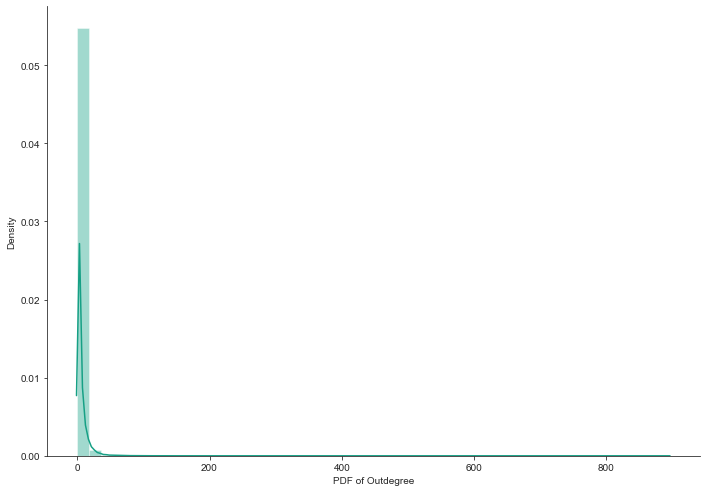

In [17]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()


Some other statistics:

In [18]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 631310 and % is 71.53370687848074


In [19]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 145806 and % is 16.521271111060752


In [20]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following
Finally, statistics of 1.1 and 1.2 can be combined.

In [21]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

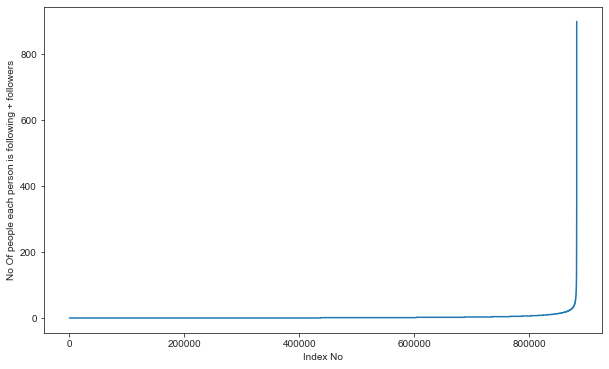

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()


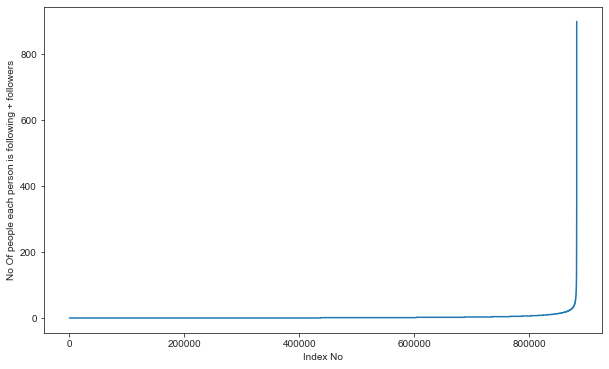

In [23]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()


In [24]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 7.0
91 percentile value is 8.0
92 percentile value is 8.0
93 percentile value is 9.0
94 percentile value is 10.0
95 percentile value is 12.0
96 percentile value is 14.0
97 percentile value is 16.0
98 percentile value is 20.0
99 percentile value is 29.0
100 percentile value is 897.0


In [25]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 30.0
99.2 percentile value is 32.0
99.3 percentile value is 34.0
99.4 percentile value is 36.0
99.5 percentile value is 39.0
99.6 percentile value is 43.0
99.7 percentile value is 50.0
99.8 percentile value is 60.0
99.9 percentile value is 84.0
100.0 percentile value is 897.0


In [26]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
436599  persons having minimum no of followers + following


In [27]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 897
1  persons having maximum no of followers + following


In [28]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 823794


In [29]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 46916
weakly connected components wit 2 nodes 29632


## 1.4 Posing a problem as classification problem 
Now that the data has been explored, the real work can begin. Firstly, the problem needs to be defined as a classification task. We need to create a training set of nodes that are linked and unlinked and generate features for all nodes that are used to train the classifier.

### 1.4.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. So eventually, we will create a training set that consists of node pairs that are connected in the real graph and node pairs that are not connected. Following code generates a set of node pairs classified as unlinked (it is assumed that two randomly chosen nodes are unconnected).

In [30]:
import random
r = csv.reader(open('./train_small.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1


missing_edges = set([])
while (len(missing_edges)<1500000):
    a=random.randint(1, 1500000)
    b=random.randint(1, 1500000)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(g,source=a,target=b) > 2: 

                missing_edges.add((a,b))
            else:
                continue  
        except:  
                missing_edges.add((a,b))     
                
len(missing_edges)

1500000

In [31]:
list(missing_edges)[:10]

[(1038129, 61884),
 (101256, 965580),
 (1154935, 492051),
 (1272271, 374296),
 (1312195, 1249204),
 (416729, 23427),
 (182342, 1480409),
 (368178, 923913),
 (1132925, 1388988),
 (1230203, 864983)]

So e.g. the nodes 1135773 and 1280100 should be classified as unlinked.

### 1.4.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing them, we used that graph for creating features for train and test data set.

In [32]:
from sklearn.model_selection import train_test_split

df_pos = pd.read_csv('./train_small.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])
    
#Trian test split 
#Spiltted data into 80-20 
#positive links and negative links seperatly because we need positive training data only for creating graph 
#and for feature generation
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

#removing header and saving
X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)

del missing_edges

Number of nodes in the graph with edges 1499999
Number of nodes in the graph without edges 1500000
Number of nodes in the train data graph with edges 1199999 = 1199999
Number of nodes in the train data graph without edges 1200000 = 1200000
Number of nodes in the test data graph with edges 300000 = 300000
Number of nodes in the test data graph without edges 300000 = 300000


In [33]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 787357
Number of edges: 1199999
Average in degree:   1.5241
Average out degree:   1.5241
Name: 
Type: DiGraph
Number of nodes: 339886
Number of edges: 300000
Average in degree:   0.8826
Average out degree:   0.8826
no of people common in train and test --  244708
no of people present in train but not present in test --  542649
no of people present in test but not present in train --  95178
 % of people not there in Train but exist in Test in total Test data are 28.002918625656836 %


Next code stores the final data sets if not already stored.

In [71]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)
else:
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    

Number of nodes in the train data graph with edges 1199999
Number of nodes in the train data graph without edges 1200000
Number of nodes in the test data graph with edges 300000
Number of nodes in the test data graph without edges 300000


# Generating features
At the moment we have a training set of node pairs that should be classified as linked, node pairs that should be classified as unlinked and a graph where we have removed the edges between nodes that are in the test set. Now we need to create features for all nodes that can be passed to a classifier. These features need to take into account the graph topology based on which we can predict if people should be linked. 

# 2. Similarity measures
A similarity measure can be defined as a real-valued function that quantifies the similarity between two objects. In this section, we will be exploring different similarity methods commonly used in graph analysis and we will be applying them in our dataset. These similarity measures will afterwards be used to create features for the nodes in a following section.

In [35]:
# From now on we will work with the variable train_graph instead of g.
train_graph=g
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 882535
Number of edges: 1500000
Average in degree:   1.6996
Average out degree:   1.6996


## 2.1 Distance measures

## 2.1.1 Jaccard Distance:
The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. So in our setting it is a way of expressing the similarity between two nodes. For more info: http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [36]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [37]:
#one test case
print(jaccard_for_followees(273084,156302))

0


In [38]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [39]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [40]:
print(jaccard_for_followers(273084,470294))

0.0


In [41]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.1.2 Cosine distance
Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. For more info: https://en.wikipedia.org/wiki/Cosine_similarity

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [42]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [43]:
print(cosine_for_followees(273084,156302))

0


In [44]:
print(cosine_for_followees(273084,1635354))

0


In [45]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [46]:
print(cosine_for_followers(2,470294))

0


In [47]:
print(cosine_for_followers(669354,1635354))

0


## 2.2 Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 2.2.1 Page Ranking

PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results. According to Google:

"PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites."

For more info: https://en.wikipedia.org/wiki/PageRank


In [48]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

In [49]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 8.58930816864722e-07
max 9.881649522394452e-06
mean 1.1330995371270275e-06


In [50]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

1.1330995371270275e-06


# 2.3. Other Graph Features
In the current section we will be addresing other important features for a complete graph anylisis.

## 2.3.1 Shortest path:

In graph theory, the shortest path problem is the problem of finding a path between two vertices (or nodes) in a graph such that the sum of the weights of its constituent edges is minimized. It is widely studied in multiple algorithmical disciplines related to graphs design because its effectiveness for analytical tasks. For more info: https://en.wikipedia.org/wiki/Cosine_similarityGetting . Following function allows to calculate the shortest path between two nodes.

In [51]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [52]:
#testing
compute_shortest_path_length(2938, 68759)

-1

In [53]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 2.3.2 Checking for same community
A community, with respect to graphs, can be defined as a subset of nodes that are densely connected to each other and loosely connected to the nodes in the other communities in the same graph. We will use the networkx method weakly_connected_components(train_graph) to define different communities and define our own function to check if two nodes belong to the same community.

In [54]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [55]:
belongs_to_same_wcc(861, 1659750)

0

In [56]:
belongs_to_same_wcc(669354,1635354)

0

## 2.3.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices. For more info: https://en.wikipedia.org/wiki/Adamic/Adar_index
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [57]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [58]:
calc_adar_in(1,189226)

2.095903274289385

In [59]:
calc_adar_in(669354,1635354)

0

## 2.3.4 Is the user following back:
Another feature we can use is to check if the user is following back.

In [60]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [61]:
follows_back(1,189226)

1

In [62]:
follows_back(669354,1635354)

0

## 2.3.5 Katz Centrality:

Katz centrality computes the centrality for a node 
based on the centrality of its neighbors. It is a 
generalization of the eigenvector centrality. The
Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $\lambda$. The parameter $\beta$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

For more info: https://en.wikipedia.org/wiki/Katz_centrality, https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [63]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

In [64]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.001055291584524605
max 0.001512480215481431
mean 0.0010644044296598304


In [65]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0010644044296598304


## 2.3.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.(Note that this algorithm may take a while) For more info: https://en.wikipedia.org/wiki/HITS_algorithm

In [67]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=200, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [68]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.03582118375996806
mean 1.133099537128857e-06


# 3. Featurization
The only thing that has to be done now is extracting features with previously defined similarity measures and add them to the nodes in the train and test sets. This will systematically be done in this section. The current training set consists of 2399999 examples (1200000 labeled 0 and 1199999 labeled 1). The test set contains 600000 examples (300000 labeled 0 and 300000 labeled 1). This was determined in section 1.4.2).

In [72]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2399999, 2399999, 600000, 600000)

In [73]:
X_train['indicator_link'] = y_train
X_test['indicator_link'] = y_test


In [82]:
df_final_train = X_train
df_final_test = X_test
#X_test['indicator_link'].value_counts()

## 3.1 Adding a set of features
Now we will systematically add features.

__we will add these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [83]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)


In [84]:
df_final_train

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees
0,143591,78996,1.0,0.000000,0.0,0.000000,0.0
1,109529,409671,1.0,0.000000,0.0,0.000000,0.0
2,158489,1766677,1.0,0.000000,0.0,0.000000,0.0
3,17836,1746118,1.0,0.333333,0.0,0.204124,0.0
4,185802,1689959,1.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
2399994,1019046,882430,0.0,0.000000,0.0,0.000000,0.0
2399995,719938,28466,0.0,0.000000,0.0,0.000000,0.0
2399996,504637,1134117,0.0,0.000000,0.0,0.000000,0.0
2399997,90832,559530,0.0,0.000000,0.0,0.000000,0.0


In [85]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [86]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

## 3.2 Adding new set of features

__we will add these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [87]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

## 3.3 Adding new set of features

__we will add these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

It is a directed graph so calculated Weighted in and Weighted out differently

In [88]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 882535/882535 [00:06<00:00, 126179.38it/s]


In [90]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [91]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 3.4 Adding new set of features

__The next feature we add for both train and test data points is the following:__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [92]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [93]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [94]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [95]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (882535, 882535)
U Shape (882535, 6)
V Shape (6, 882535)
s Shape (6,)


In [96]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

In [97]:
train_nodes = df_final_train[['source_node', 'destination_node']]
train_nodes.to_csv('./train_nodes.csv',header=False,index=False)

In [98]:
test_nodes = df_final_test[['source_node', 'destination_node']]
test_nodes.to_csv('./test_nodes.csv',header=False,index=False)

# 3.5 Graph embedding

Graph embedding is an approach that is used to transform nodes, edges, and their features into vector space (a lower dimension) whilst maximally preserving properties like graph structure and information. There are several approaches that are commonly used in Graph Embedding. We have selected Node2Vec as we believe it fits the characteristics of our dataset.

Node2vec features a walk bias variable α, which is parameterized by p and q. The parameter p prioritizes a breadth-first-search (BFS) procedure, while the parameter q prioritizes a depth-first-search (DFS) procedure. The decision of where to walk next is therefore influenced by probabilities 1/p or 1/q.

For more info: https://towardsdatascience.com/overview-of-deep-learning-on-graph-embeddings-4305c10ad4a4#

Note, in the following code we create two embeddings: one for the train graph (this is used to train the classifier). To test the model, we need to create an independent embedding of the test graph. The node2vec implementation of the following library is used: https://github.com/eliorc/node2vec . The graph embedding will consist of 10 dimensions and a walk lenght of 10 is used in the random walks.

In [99]:
subgraph_for_embedding=nx.read_edgelist('train_nodes.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(subgraph_for_embedding))   

subgraph2_for_embedding=nx.read_edgelist('test_nodes.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(subgraph2_for_embedding))   

Name: 
Type: DiGraph
Number of nodes: 1456542
Number of edges: 2399999
Average in degree:   1.6477
Average out degree:   1.6477
Name: 
Type: DiGraph
Number of nodes: 737582
Number of edges: 600000
Average in degree:   0.8135
Average out degree:   0.8135


In [100]:
from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(subgraph_for_embedding, dimensions=10, walk_length=8, num_walks=10)
# Learn embeddings 
model1 = node2vec.fit(window=5, min_count=1)


Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [40:15<00:00, 241.55s/it]


In [101]:
node2vec2 = Node2Vec(subgraph2_for_embedding, dimensions=10, walk_length=8, num_walks=10)
# Learn embeddings 
model2 = node2vec2.fit(window=5, min_count=1)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [16:36<00:00, 99.67s/it]


In [102]:
train_emb = []
test_emb = []

    
for ele in df_final_train['source_node']:
    try:
        train_emb.append(model1.wv[ele])
    except:
        train_emb.append(np.zeros(10))
    
for ele in df_final_test['source_node']:
    try:
        test_emb.append(model2.wv[ele])
    except:
        test_emb.append(np.zeros(10))

In [103]:
train_em = pd.DataFrame(train_emb)
test_em = pd.DataFrame(test_emb)

In [104]:
train_full = pd.concat([df_final_train, train_em], axis=1, join="inner")
test_full = pd.concat([df_final_test, test_em], axis=1, join="inner")

In [105]:
hdf = HDFStore('data/fea_sample/storage_sample_stage5.h5')
hdf.put('train_df',train_full, data_columns=True)
hdf.put('test_df',test_full, data_columns=True)
hdf.close()

In [106]:
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r+')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r+')

The following summarizes all the extracted features for all nodes (the columns of df_final_train). Note that it is this matrix that requires a lot of memory because of the large amount of nodes.

In [107]:
df_final_train.columns

Index([      'source_node',  'destination_node',    'indicator_link',
       'jaccard_followers', 'jaccard_followees',  'cosine_followers',
        'cosine_followees',   'num_followers_s',   'num_followers_d',
         'num_followees_s',   'num_followees_d',   'inter_followers',
         'inter_followees',        'adar_index',      'follows_back',
               'same_comp',     'shortest_path',         'weight_in',
              'weight_out',         'weight_f1',         'weight_f2',
               'weight_f3',         'weight_f4',       'page_rank_s',
             'page_rank_d',            'katz_s',            'katz_d',
                  'hubs_s',            'hubs_d',     'authorities_s',
           'authorities_d',                   0,                   1,
                         2,                   3,                   4,
                         5,                   6,                   7,
                         8,                   9],
      dtype='object')

In [108]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [109]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

The following code produces the head of the df_final_train. Note the last 10 columns which are the extracted node2vec features of every node.

In [110]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.0,0.000000,0.0,5,2,241,8,0,0,...,0.021382,-1.240920,-0.673099,0.404840,0.549191,-0.389357,-0.262482,0.270091,-0.738968,-0.054119
1,0.000000,0.0,0.000000,0.0,0,1,2,0,0,0,...,-0.664207,-1.356856,-0.075970,-0.667520,0.844451,-1.265052,-0.859328,-0.380905,-1.711755,1.250844
2,0.000000,0.0,0.000000,0.0,0,2,5,0,0,0,...,0.186369,-0.672336,-0.279649,0.253951,0.254500,-0.504595,-0.032917,0.072711,-0.478684,0.117394
3,0.333333,0.0,0.204124,0.0,6,6,58,0,3,0,...,0.151785,-1.135811,-0.670569,1.537238,-0.442615,-1.776014,0.867644,-0.340891,-0.956517,0.090750
4,0.000000,0.0,0.000000,0.0,1,7,8,0,0,0,...,0.237434,-1.383445,-1.170076,-0.340379,1.167126,-0.954783,0.150731,1.005187,-0.774172,-0.395472


# 4 Training the classifier
Now that we have a set of nodes with features, we can easily train a machine learning model to perform link prediction on new instances. Note that running of the code cells below can take a long time. Firstly, the model parameter tuning is performed in section 4.1 - 4.3. Then, the optimal parameters are applied and tested in a final model.
## 4.1 Training on all features
The first classifier (below) trains a random forest model taking into account all the features. High scores on the test set are reached with this model (~91%). The first hyperparameter we tune is the "estimators" parameter in RandomForestClassifier of sklearn. We take its optimal value as 50.

Estimators =  10 Train Score 0.971889270851008 test Score 0.9126415902664724
Estimators =  50 Train Score 0.9716870174705569 test Score 0.9170186246442765
Estimators =  100 Train Score 0.9717145567536906 test Score 0.9159567331736801
Estimators =  250 Train Score 0.971720064797641 test Score 0.9158358712426424
Estimators =  450 Train Score 0.9717251794657932 test Score 0.9129083996775083


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

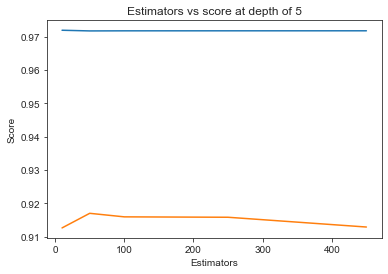

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

## 4.2 Training only on Node2vec features
In the following code we also try to fit a model when taking into account only the graph embedding features. We conclude (based on the graph of the test score) that this gives a very poor performance, so other features also need to be incorporated in the training set.

In [127]:
train_emb_only = df_final_train[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
test_emb_only = df_final_test[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

Estimators =  10 Train Score 0.8280673936623907 test Score 0.00370498476765688
Estimators =  50 Train Score 0.828537105768024 test Score 0.002695543368297748
Estimators =  100 Train Score 0.8287229646612213 test Score 0.002808521400001331
Estimators =  250 Train Score 0.8288698194766921 test Score 0.00244960992624544
Estimators =  450 Train Score 0.8287734250334807 test Score 0.0026091326297993564


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

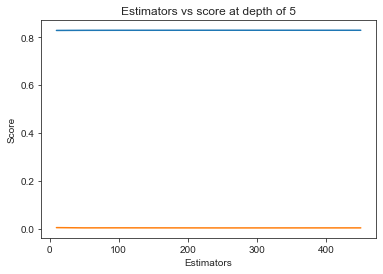

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(train_emb_only,y_train)
    train_sc = f1_score(y_train,clf.predict(train_emb_only))
    test_sc = f1_score(y_test,clf.predict(test_emb_only))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

The we determine the "depth" parameter. Based on the figure below, we set the optimal depth of the classification trees at 3.

depth =  3 Train Score 0.9662431150133609 test Score 0.9125165164334188
depth =  9 Train Score 0.9796078812353076 test Score 0.8604559547692868
depth =  11 Train Score 0.9838811796739166 test Score 0.846956783706533
depth =  15 Train Score 0.9881674593378842 test Score 0.79988429341782
depth =  20 Train Score 0.9886134446846788 test Score 0.801429749578853
depth =  35 Train Score 0.9888611899887737 test Score 0.7889323785788482
depth =  50 Train Score 0.9888786157707041 test Score 0.7910183784892215


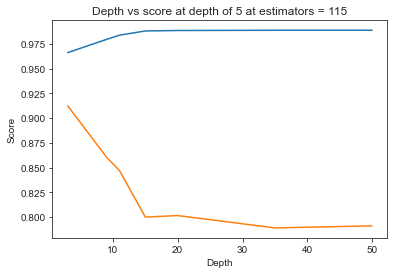

In [114]:
depths = [3,9,11,15,20,35,50]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [115]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(10,125),
              "max_depth": sp_randint(1,15),
              "min_samples_split": sp_randint(10,190),
              "min_samples_leaf": sp_randint(5,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97171026 0.97466238 0.98756125 0.98156327 0.97159028]


In [116]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=13, min_samples_split=166,
                       n_estimators=14, n_jobs=-1, random_state=25)


## 4.3 Final model evaluation
Below we define the final random forest classifier with parameters as determined in previous sections. We use f1 scores, confusion matrices and ROC curves as evaluation metrics.

In [117]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=114,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [118]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

The f1 score on the test set reaches 90%.

In [119]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9612128409669869
Test f1 score 0.9006787345765421


In [120]:
# Helper function to plot confusioin matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Confustion matrices indicate a good classifier performance. At least 90% of nodes are classified correctly. It is also observed (from the precision matrix) that the model makes most errors by classifying class 1 as class 0 in the test set.

Train confusion_matrix


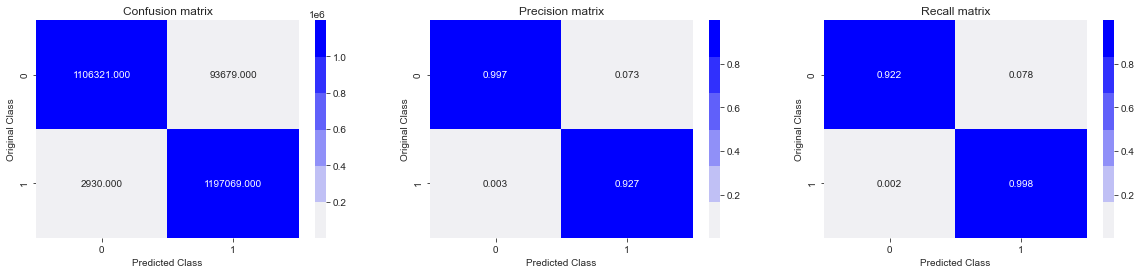

Test confusion_matrix


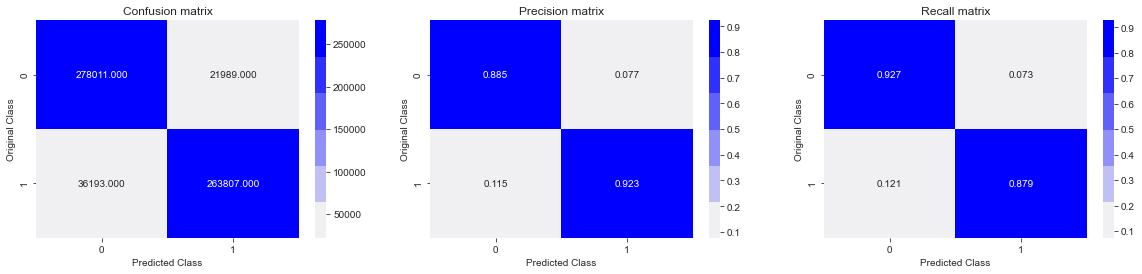

In [121]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

Below, we model the ROC curve which plots the true positive rate as a function of the false positive rate.

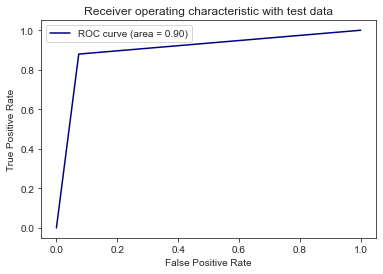

In [122]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

We can also look at the relative importances of the different features. It appears that especially the weight features and number of followers/followees are important in the classification process. Also some of the graph embedding features are used with intermediate importances while some of the embedding features are not used at all.

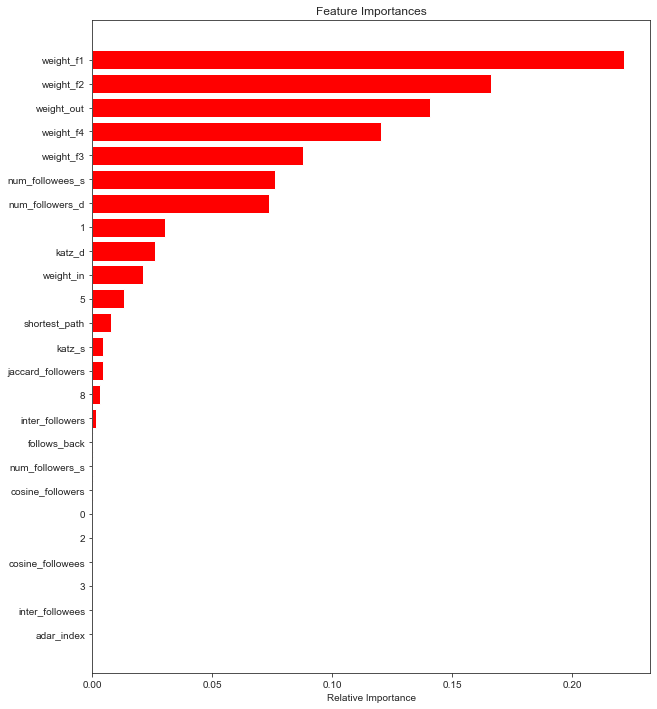

In [123]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4.4 MLP model
As a final test, we try training a MLP neural network on the training data and evaluate its performance with confusion matrices. The model has comparable performance to the random forest classifier.

In [124]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300, verbose=1).fit(df_final_train, y_train)
clf.score(df_final_test, y_test)

Iteration 1, loss = 0.05737345
Iteration 2, loss = 0.04780291
Iteration 3, loss = 0.04713520
Iteration 4, loss = 0.04674468
Iteration 5, loss = 0.04654391
Iteration 6, loss = 0.04640289
Iteration 7, loss = 0.04629162
Iteration 8, loss = 0.04623269
Iteration 9, loss = 0.04614846
Iteration 10, loss = 0.04601144
Iteration 11, loss = 0.04598761
Iteration 12, loss = 0.04596316
Iteration 13, loss = 0.04594761
Iteration 14, loss = 0.04590835
Iteration 15, loss = 0.04591056
Iteration 16, loss = 0.04585240
Iteration 17, loss = 0.04591249
Iteration 18, loss = 0.04586020
Iteration 19, loss = 0.04584760
Iteration 20, loss = 0.04583672
Iteration 21, loss = 0.04579659
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


0.9504783333333333

In [125]:
clf.score(df_final_test, y_test)

0.9504783333333333

Train confusion_matrix


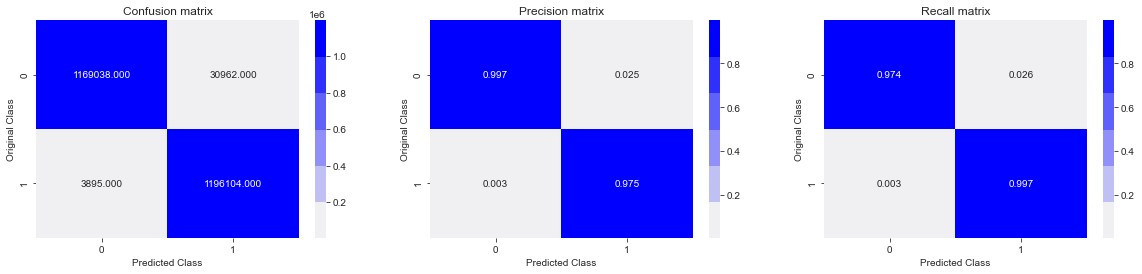

Test confusion_matrix


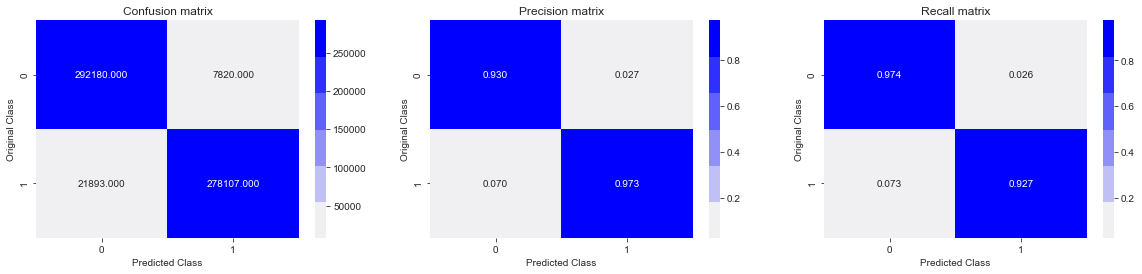

In [126]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

# 5. Conclusion
We have created a model which is able to predict new friendship recommendations based on a facebook dataset. First, a large amount of features are extracted from the graph data (including graph embedding using node2vec) and a training and test set were created. Then , a random forest classifier is trained with an eye on classifying node pairs that should be linked as 1 and nodes that should not be linked as 0. All assessed performance metrics indicate that the final classifier has an acceptable perfomance for this task. Finally, it was also observed that not all features af of equal importance in the classification task (e.g. some embedding features remain unused in the model).

-- Task distribution --

Vishal Rajput $\rightarrow$ Code

Nicolas Dubois + Javier Romero $\rightarrow$ Graph embedding + documentation